In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [2]:
# чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

# Baseline Prophet

In [3]:
# обучение модели baseline prophet
bl_prophet = Prophet()
bl_prophet.fit(df_train)

02:35:03 - cmdstanpy - INFO - Chain [1] start processing
02:35:03 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = bl_prophet.make_future_dataframe(periods=365, freq='D')
forecast = bl_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2716,2024-03-05,13.919675,11.552239,16.211682
2717,2024-03-06,14.038301,11.585728,16.536699
2718,2024-03-07,14.093533,11.807488,16.585989
2719,2024-03-08,14.149100,11.829255,16.775683
2720,2024-03-09,14.921460,12.532992,17.438839
2721,2024-03-10,14.973605,12.472470,17.307596
2722,2024-03-11,14.270169,11.910713,16.667544
2723,2024-03-12,14.317111,11.862926,16.875666
2724,2024-03-13,14.401140,11.785613,16.888118
2725,2024-03-14,14.420674,11.911864,16.757095


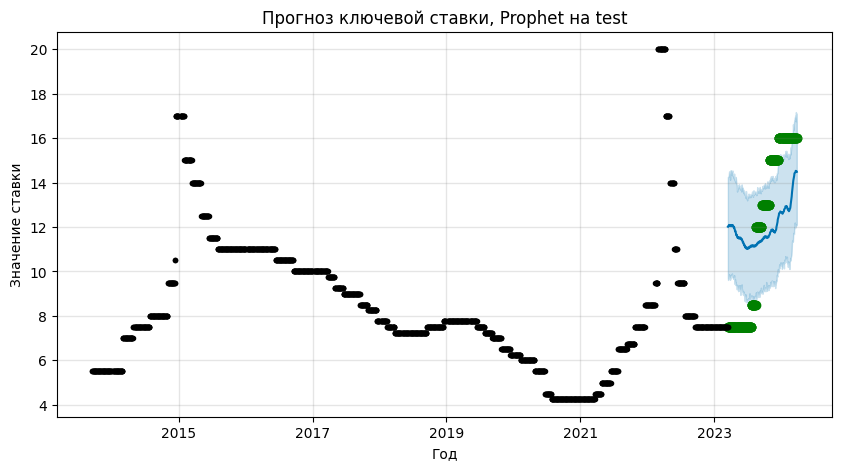

In [5]:
# смотрим совпадение фактического курса с предсказанным курсом baseline prophet
fig, ax = plt.subplots(figsize= (10, 5))

predict = bl_prophet.predict(df_test)
fig = bl_prophet.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

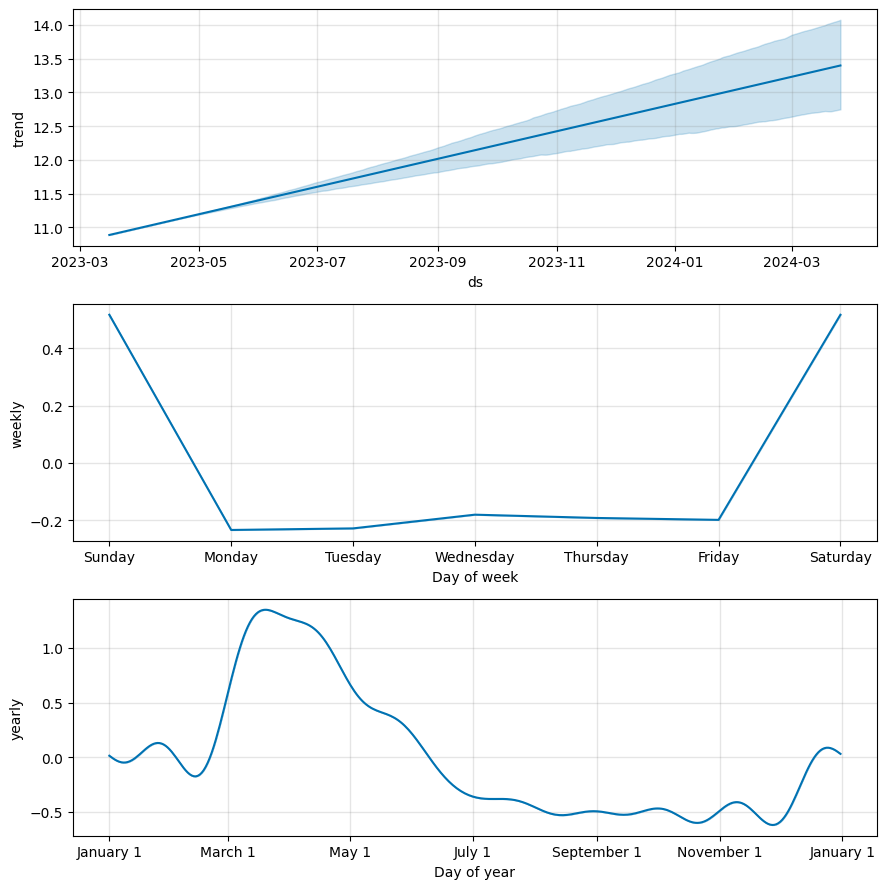

In [6]:
# смотрим тренд, годовые и сезонные признаки
fig = bl_prophet.plot_components(predict)
plt.show()

In [12]:
df_test_forecast = bl_prophet.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
252,2024-03-13,14.401140,11.810462,16.854268
253,2024-03-14,14.420674,11.910637,16.736897
254,2024-03-15,14.440112,11.971441,16.811765
255,2024-03-18,14.456496,11.967064,16.954884
256,2024-03-19,14.471633,11.835958,16.996253
257,2024-03-20,14.526173,12.007601,16.856136
258,2024-03-21,14.518877,12.099740,16.887416
259,2024-03-22,14.514408,11.926373,16.618187
260,2024-03-25,14.477894,11.735766,16.906199
261,2024-03-26,14.481666,12.000691,16.921339


In [24]:
df_test

,ds,y
0,2023-03-16,7.5
1,2023-03-17,7.5
2,2023-03-20,7.5
3,2023-03-21,7.5
4,2023-03-22,7.5
...,...,...
257,2024-03-20,16.0
258,2024-03-21,16.0
259,2024-03-22,16.0
260,2024-03-25,16.0


In [23]:
df_test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-03-16,10.888574,9.684454,14.357436,10.888574,10.888574,1.125881,1.125881,1.125881,-0.191942,-0.191942,-0.191942,1.317823,1.317823,1.317823,0.0,0.0,0.0,12.014455
1,2023-03-17,10.895249,9.701108,14.351087,10.895249,10.895249,1.132862,1.132862,1.132862,-0.198551,-0.198551,-0.198551,1.331412,1.331412,1.331412,0.0,0.0,0.0,12.028111
2,2023-03-20,10.915274,9.582109,14.276850,10.915274,10.915274,1.114813,1.114813,1.114813,-0.233763,-0.233763,-0.233763,1.348576,1.348576,1.348576,0.0,0.0,0.0,12.030087
3,2023-03-21,10.921949,9.846567,14.456438,10.921949,10.921949,1.119604,1.119604,1.119604,-0.228316,-0.228316,-0.228316,1.347920,1.347920,1.347920,0.0,0.0,0.0,12.041553
4,2023-03-22,10.928624,9.912075,14.354094,10.928624,10.928624,1.164398,1.164398,1.164398,-0.180470,-0.180470,-0.180470,1.344868,1.344868,1.344868,0.0,0.0,0.0,12.093022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2024-03-20,13.358315,12.007601,16.856136,12.604264,14.031228,1.167858,1.167858,1.167858,-0.180470,-0.180470,-0.180470,1.348327,1.348327,1.348327,0.0,0.0,0.0,14.526173
258,2024-03-21,13.364990,12.099740,16.887416,12.606766,14.044904,1.153887,1.153887,1.153887,-0.191942,-0.191942,-0.191942,1.345829,1.345829,1.345829,0.0,0.0,0.0,14.518877
259,2024-03-22,13.371665,11.926373,16.618187,12.608273,14.056189,1.142743,1.142743,1.142743,-0.198551,-0.198551,-0.198551,1.341294,1.341294,1.341294,0.0,0.0,0.0,14.514408
260,2024-03-25,13.391690,11.735766,16.906199,12.624120,14.081596,1.086204,1.086204,1.086204,-0.233763,-0.233763,-0.233763,1.319967,1.319967,1.319967,0.0,0.0,0.0,14.477894


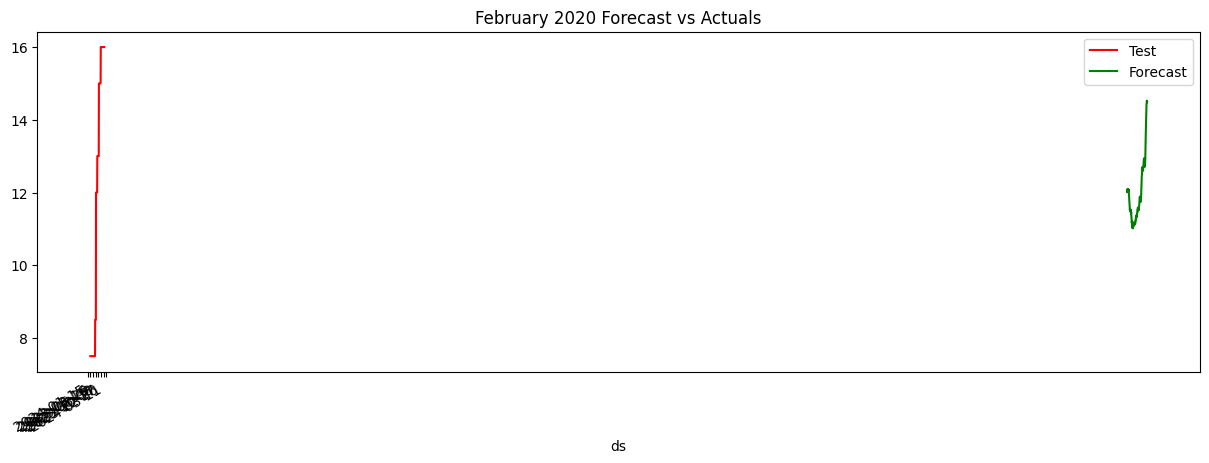

In [28]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line', x='ds', y='yhat', color='green', label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [29]:
import holidays

In [31]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [32]:
holiday

,ds,holiday
0,2013-01-01,RU-Holidays
1,2013-01-02,RU-Holidays
2,2013-01-03,RU-Holidays
3,2013-01-04,RU-Holidays
4,2013-01-05,RU-Holidays
...,...,...
165,2024-03-08,RU-Holidays
166,2024-05-01,RU-Holidays
167,2024-05-09,RU-Holidays
168,2024-06-12,RU-Holidays


In [ ]:
# выводиим метрики для оценкии baseline prophet 
get_metrics = get_metrics(y_test=df_test['y'], y_pred=predict['yhat'], name='Baseline Prophet')
get_metrics

1. Mean Absolute Error (MAE) - Среднее абсолютное отклонение позволяет оценить среднее абсолютное отклонение прогнозов от фактических значений. Чем ниже MAE, тем лучше модель.
2. Mean Absolute Percentage Error (MAPE) - Среднее абсолютное процентное отклонение показывает средний процент ошибки прогноза от фактических значений. Чем ниже MAPE, тем лучше.
3. Mean Squared Error (MSE) - Среднеквадратичное отклонение предоставляет информацию о среднеквадратичном отклонении прогнозов от фактических значений. Чем ниже MSE, тем лучше модель.
4. Root Mean Squared Error (RMSE) - Квадратный корень из MSE помогает интерпретировать стандартное отклонение прогнозов от фактических значений.

# Tuning Prophet

## Hyperparameter tuning

In [ ]:
# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [ ]:
# выводиим метрики для оценкии tuning prophet 
#metrics = pd.concat([metrics, get_metrics(y_test=df_cv['y'], y_pred=df_cv['yhat'], name='CV Prophet')])
#metrics